/home/mmc/anaconda3/envs/CPR_YOLO/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mmc/anaconda3/envs/CPR_YOLO/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/mmc/anaconda3/envs/CPR_YOLO/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[ 894  664   89 1560 1573  983  363  994  364 1028]
[-75.78546  -77.00416  -77.57119  -78.13216  -78.280014 -79.51889
 -80.55148  -80.55232  -80.63087  -80.754   ]
[894]
Test Predictions: 이멕스무역)후지야룩4


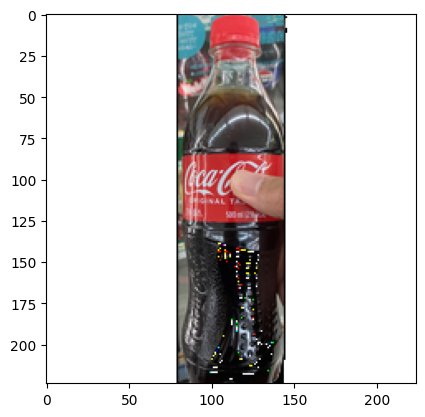

In [1]:
import torch
from torchvision import transforms
from PIL import Image
from transformers import pipeline
import numpy as np
import torch.nn as nn
import timm
import pandas as pd
import matplotlib.pyplot as plt
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "4"

class CustomImageClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CustomImageClassifier, self).__init__()
        self.base_model = timm.create_model('resnet18.a1_in1k', pretrained=True, num_classes=num_classes)

    def forward(self, x):
        x = self.base_model(x)
        return x

def remove_background(image_path):
    pipe = pipeline("image-segmentation", model="briaai/RMBG-1.4", device=0, trust_remote_code=True)  # device=0 설정으로 GPU 사용

    pillow_mask = pipe(image_path, return_mask=True)
    pillow_image = pipe(image_path)

    np_image = np.array(pillow_image)

    np_image[np_image == 0] = 255

    modified_image = Image.fromarray(np_image)

    if modified_image.mode == 'RGBA':
        modified_image = modified_image.convert('RGB')

    return modified_image

def get_product_name(class_id, csv_path='path_to_csv_file.csv'):
    df = pd.read_csv(csv_path)
    class_to_name = df.set_index('class')['img_prod_nm'].to_dict()
    return class_to_name.get(class_id, "Unknown Product")

# 변환 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 모델 로드 함수
def load_model(model_path, model, device='cuda'):
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

# 추론 함수
def inference(model, image, device='cuda'):
    model.eval()
    with torch.no_grad():
        image = image.to(device).unsqueeze(0)  # 배치를 추가하기 위해 unsqueeze(0)을 사용
        outputs = model(image)
        logits = outputs.cpu().numpy()
        top10_indices = np.argsort(logits[0])[::-1][:10]
        print(top10_indices)
        print(logits[0][top10_indices])
        _, preds = torch.max(outputs, 1)
    return preds.cpu().numpy()



# 모델 경로 및 이미지 경로
# best_model_path = '/home/mmc/disk2/duck/cap/cnn/noodle_pt/model_epoch_50_loss_0.0074.pt'
# best_model_path = '/home/mmc/disk2/duck/cap/cnn/drink_pt_0518_resnet18/best.pt'
best_model_path = '/home/mmc/disk2/duck/cap/cnn/snack_pt_0517_resnet18/best.pt'

image_path = "/home/mmc/disk2/duck/cap/data/drink/test/individual_crop_1_square_224x224.png"

# csv_path = '/home/mmc/disk2/duck/cap/data/csv/train/noodle.csv'
# csv_path = '/home/mmc/disk2/duck/cap/data/csv/train/drink.csv'
csv_path = '/home/mmc/disk2/duck/cap/data/csv/train/snack.csv'


num_classes = 1637  # drink 1044 noodle 205 snack 1637

# 이미지 로드 및 변환
image = remove_background(image_path)
plt.imshow(image)
image = transform(image)

# 모델 정의 및 로드
model = timm.create_model('resnet18.a1_in1k', pretrained=True, num_classes=num_classes)
model.to('cuda')
model = load_model(best_model_path, model, device='cuda')

# 추론 수행

test_predictions = inference(model, image, device='cuda')
result = get_product_name(test_predictions[0], csv_path)
print(test_predictions)
print(f'Test Predictions: {result}')


In [4]:
import timm
import torch
from torch import nn
from torchvision import transforms
from PIL import Image

# 모델 로드 (예: EfficientNet-B0)
model = timm.create_model('resnet18.a1_in1k', pretrained=True)

# 새로운 이미지 크기로 미세 조정하기 위해 마지막 레이어를 조정
num_classes = 10  # 예를 들어, 새로운 데이터셋의 클래스 수가 10인 경우

# 전처리 정의 (예: 3:4 비율의 300x400 이미지 사용)
preprocess = transforms.Compose([
    transforms.Resize((300, 400)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 예시 이미지 로드 및 전처리
img = Image.open('/home/mmc/disk2/duck/cap/DeepLabV3+/images/train/0001.jpg')  # 예시 이미지 경로
img_t = preprocess(img)
img_t = img_t.unsqueeze(0)  # 배치 차원 추가

# 모델 예측 (미세 조정 전)
model.eval()
with torch.no_grad():
    output = model(img_t)

print(output)


tensor([[-10.7709, -11.1713, -10.1762, -11.6322, -10.3776, -10.7012, -10.1619,
         -11.9084, -12.1358, -13.2353, -12.6062, -10.4200, -11.9657, -12.0429,
         -12.0708, -12.2304, -13.2486, -12.8422, -11.7089, -12.2174, -12.3434,
         -12.0629, -12.4891, -12.7705, -12.6898, -11.6480, -12.4651, -12.3021,
         -13.0081, -10.7234, -11.6332, -11.7818, -11.5926, -11.2772, -10.8282,
         -10.5685,  -8.9909,  -9.9344, -11.9535, -12.1633, -13.0927, -12.4172,
         -12.4560, -12.3211, -12.1311, -11.9033, -12.4036, -11.7869, -11.7160,
         -12.1852, -11.0940, -11.1697, -10.8302, -10.4410, -11.0669, -12.0213,
         -11.6943, -11.7944, -10.8315, -10.8240, -10.6585, -10.4163, -10.9484,
         -10.9464, -11.1699, -10.4202, -12.0315, -11.1531, -12.1149, -10.4251,
         -12.4787, -10.8046, -11.3201, -10.6002, -11.2820, -10.4874, -10.2917,
         -11.3135,  -9.3796, -10.5187, -12.9616, -13.2302, -12.6611, -14.2957,
         -11.4333, -12.0124, -12.8529,  -9.6010, -11

In [5]:
import os
from PIL import Image

# Define the directory containing the images
image_dir = "/home/mmc/disk2/duck/cap/DeepLabV3+/images/train"

# Loop through all files in the directory
for filename in os.listdir(image_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        # Open an image file
        img_path = os.path.join(image_dir, filename)
        img = Image.open(img_path)
        
        # Crop the image to 768x768
        width, height = img.size
        new_width, new_height = 768, 768
        
        left = (width - new_width) / 2
        top = (height - new_height) / 2
        right = (width + new_width) / 2
        bottom = (height + new_height) / 2
        
        img_cropped = img.crop((left, top, right, bottom))
        
        # Resize the image to 224x224
        img_resized = img_cropped.resize((224, 224), Image.ANTIALIAS)
        
        # Save the processed image
        img_resized.save(img_path)

print("All images have been cropped and resized.")


  0%|          | 0/93934 [00:00<?, ?it/s]/tmp/ipykernel_45009/2112423446.py:31: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = cropped_img.resize((resize_width, resize_height), Image.ANTIALIAS)
  2%|▏         | 1680/93934 [03:02<2:46:43,  9.22it/s]


KeyboardInterrupt: 

In [9]:
import os
from PIL import Image

# Define the source and destination directories
source_dir = "/home/mmc/disk2/duck/cap/DeepLabV3+/masks/val"
destination_dir = "/home/mmc/disk2/duck/cap/DeepLabV3+/masks_224/val"

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Loop through all files in the source directory
for filename in os.listdir(source_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        # Open an image file
        img_path = os.path.join(source_dir, filename)
        img = Image.open(img_path)
        
        # Crop the image to 768x768
        width, height = img.size
        new_width, new_height = 768, 768
        
        left = (width - new_width) / 2
        top = (height - new_height) / 2
        right = (width + new_width) / 2
        bottom = (height + new_height) / 2
        
        img_cropped = img.crop((left, top, right, bottom))
        
        # Resize the image to 224x224
        img_resized = img_cropped.resize((224, 224), Image.ANTIALIAS)
        
        # Save the processed image to the destination directory
        dest_path = os.path.join(destination_dir, filename)
        img_resized.save(dest_path)

print("All images have been cropped, resized, and saved to the new directory.")


/tmp/ipykernel_45009/1646867410.py:30: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img_resized = img_cropped.resize((224, 224), Image.ANTIALIAS)


All images have been cropped, resized, and saved to the new directory.
